In [37]:
import pandas as pd
import numpy as np
import networkx as nx
import scipy.io
from datetime import datetime
%matplotlib inline

In [38]:
motes = ["0024","003a","0047","003f","0046","004a","0024","0048","0055","0037","004f","0040","002f"]
motedict = {}
for m in motes:
    df = pd.read_csv("soda_data/{0}.csv".format(m),names=[0,m])
    df = df.set_index(pd.to_datetime(df.pop(0), unit='ns'))
    df = df.resample('10min').mean()
    motedict[m] = df
for m, df in motedict.items():
    print df.count()

0048    832
dtype: int64
0024    416
dtype: int64
0040    832
dtype: int64
0037    832
dtype: int64
0046    832
dtype: int64
0047    832
dtype: int64
002f    832
dtype: int64
0055    831
dtype: int64
004a    832
dtype: int64
003f    814
dtype: int64
003a    832
dtype: int64
004f    832
dtype: int64


832


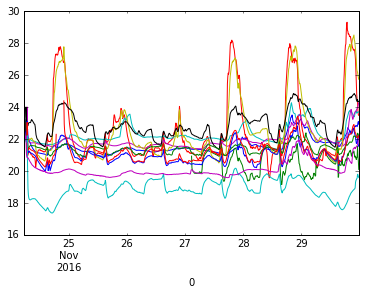

In [39]:
# merge
dfs = motedict.values()
current = dfs[0]
for df in dfs[1:]:
    current = current.merge(df, how='outer',left_index=True, right_index=True)
print len(current)
current.plot(legend=False)

11


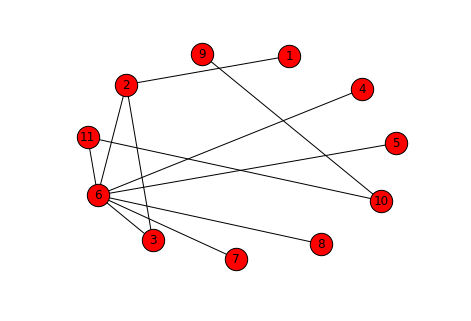

In [40]:
# need the soda printout map!  Then we assign nodes, etc
mote_mapping = {
    '0047': 1,
    '002f': 2,
    '0037': 3,
    '004f': 4,
    '0048': 5,
    '004a': 7,
    '0046': 8,
    '003a': 9,
    '0024': 10,
    '0055': 11
}
edges = [
    (1,2),
    (2,6),
    (2,3),
    (3,6),
    (4,6),
    (5,6),
    (6,7),
    (6,8),
    (9,10),
    (10,11),
    (11,6)
]
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, iterations=500, k=2.0, scale=10.0)
nx.draw(G,pos,node_size=500,with_labels=True)
nodes = G.nodes()
minNode = min(nodes)
edges = G.edges()
edges = [(nodes.index(x)+1,nodes.index(y)+1) for (x,y) in edges]
e = np.array(edges, dtype=object)
print len(e)
scipy.io.savemat('soda_amplab_edges.mat',{'edges': e})

In [41]:
# want to rename the data columns in terms of which node in the graph they are
# also need data for all of the nodes: "easiest" way is to take average of temperatures of nearby nodes
# This is what gets put in 'sdh_idea1.csv'

# First take our empirical data and replace the keti ids with the node ids
current = current[mote_mapping.keys()].rename(columns=mote_mapping)
# Now we need to "fill" the graph: For each node for which we have original data (make this list at the beginning),
# we do a breadth-first traversal through the tree. At each node we visit, its temperature becomes the average of
# its neighboring nodes; if the node's neighbors do not have any values, then we just use the value we are
# propagating from; if the node already has a value (that's not an empirical value), then its new value is the
# average of its new temperature and its neighbors (using the propagating value if neighbors have no values)
empirical_nodes = current.columns
print empirical_nodes
data_row = current.iloc[0]
result = pd.DataFrame()
rownum = 0
t = datetime.now()
for row in current.iterrows():
    rownum += 1
    for en in empirical_nodes:
        data_row = row[1]
        if pd.isnull(data_row[en]):
            #print en,'has no data'
            continue
        propagate_point = data_row[en]
        bfs_edges = nx.algorithms.traversal.bfs_edges(G, en)
        # the 2nd item (index 1) of each edge is the next node
        bfs_nodes = [x[1] for x in bfs_edges if x[1] not in empirical_nodes or pd.isnull(data_row[x[1]])]
        for node in bfs_nodes:
            neighbors = G.neighbors(node)
            # get data from neighbors
            datas = [data_row.get(n, propagate_point) for n in neighbors]
            # get data from ourself
            datas.append(data_row.get(node, propagate_point))
            # filter out nans
            datas = filter(lambda x: not pd.isnull(x), datas)
            data_row[node] = np.mean(datas)
    if rownum % 1000 == 0:
        print rownum, len(current), (datetime.now()-t).total_seconds()
        t = datetime.now()
    result = result.append(data_row)

Int64Index([5, 2, 8, 10, 11, 7, 3, 9, 4, 1], dtype='int64')


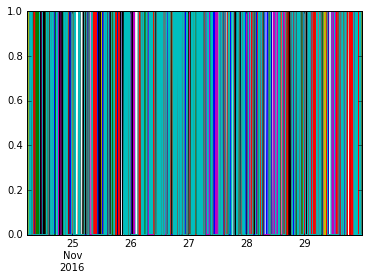

In [42]:
# compute whether or not temperature going up or not
df = result.copy()
diffs = df.interpolate(method='time').diff(axis=0)
diffs[diffs > 0] = 1
diffs[diffs < 0] = 0
diffs = diffs.fillna(0)
diffs.plot(legend=False)
diffs.tail()
diffs.to_csv("soda_amplab_data.csv",sep="\t",header=False,index=False)

In [ ]:
# TODO: need a method that takes the log likelihood and theta from the
# output and then associates them with the edges
# TODO: compare different methods and look at their log-likelihoods
# TODO: make the list of figures you will have